# Fish Classifier 🐠

### Introduction

The goal of this work is to explore different method in order to classify a set of fish

In [1]:
import numpy as np
import math

from pathlib import Path

import os

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
from keras import layers, optimizers, models
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

### Import Dataset

The dataset has been downloaded from 

https://www.kaggle.com/crowww/a-large-scale-fish-dataset

In [2]:
image_dir = Path('./archive/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()

,Filepaths,Labels
0,archive/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
1,archive/Fish_Dataset/Fish_Dataset/Red Mullet/0...,Red Mullet
2,archive/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel
3,archive/Fish_Dataset/Fish_Dataset/Red Sea Brea...,Red Sea Bream
4,archive/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat


Here there are some examples

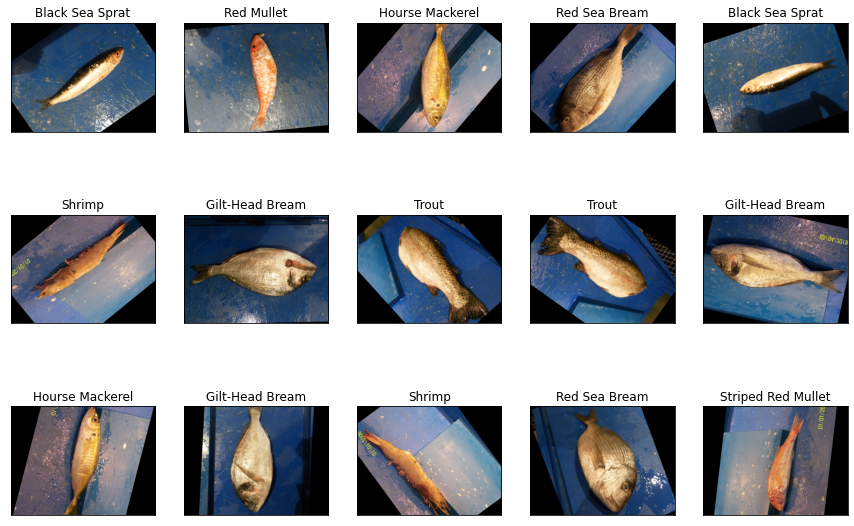

In [3]:
#Displaying a subsample of the dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepaths[i]))
    ax.set_title(image_df.Labels[i])
    
plt.show()

Now I separate in train and test data

In [4]:
train_df, test_df = train_test_split(image_df, train_size=0.85, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.15
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 6503 validated image filenames belonging to 9 classes.
Found 1147 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


Create the model and then train it

Here is the graph

![image](./optimize_lambda_eta.pdf)

In [11]:
def CreateCNN(lmbd = 0.0, eta = 0.001):
    input_shape = (224, 224, 3)
    model = tf.keras.models.Sequential(name="FishCNN")

    model.add(tf.keras.layers.Conv2D(9, (3,3), activation='elu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Conv2D(18, (3,3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Conv2D(24, (3,3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))

    model.compile(optimizer=Adam(learning_rate=eta), loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [55]:
lmbd_best = 1e-5
eta_best = 1e-3

model = CreateCNN(lmbd=lmbd_best, eta=eta_best)

model.summary()

Model: "FishCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 222, 222, 9)       252       
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 111, 111, 9)       0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 109, 109, 18)      1476      
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 54, 54, 18)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 52, 52, 24)        3912      
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 26, 26, 24)        0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 24, 24, 32)        6944

In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3,restore_best_weights=True)

MAX_EPOCHS = 10
history = model.fit(
    train_images,
    epochs = MAX_EPOCHS,
    validation_data = val_images,
    callbacks = callback
)

Epoch 1/10
102/102 [==============================] - 176s 2s/step - loss: 1.1621 - accuracy: 0.5950 - val_loss: 0.4559 - val_accuracy: 0.8457
Epoch 2/10
102/102 [==============================] - 169s 2s/step - loss: 0.3595 - accuracy: 0.8773 - val_loss: 0.2591 - val_accuracy: 0.9058
Epoch 3/10
102/102 [==============================] - 171s 2s/step - loss: 0.2104 - accuracy: 0.9302 - val_loss: 0.2183 - val_accuracy: 0.9303
Epoch 4/10
102/102 [==============================] - 176s 2s/step - loss: 0.0863 - accuracy: 0.9751 - val_loss: 0.0941 - val_accuracy: 0.9738
Epoch 5/10
102/102 [==============================] - 170s 2s/step - loss: 0.0644 - accuracy: 0.9823 - val_loss: 0.1565 - val_accuracy: 0.9538
Epoch 6/10
102/102 [==============================] - 174s 2s/step - loss: 0.1305 - accuracy: 0.9617 - val_loss: 0.1735 - val_accuracy: 0.9547
Epoch 7/10
102/102 [==============================] - 172s 2s/step - loss: 0.0873 - accuracy: 0.9757 - val_loss: 0.1630 - val_accuracy: 0.9538

Now we can evaluate the model performance looking at accuracy and loss functions and eveluating it on the test sample which is not been used already

[]

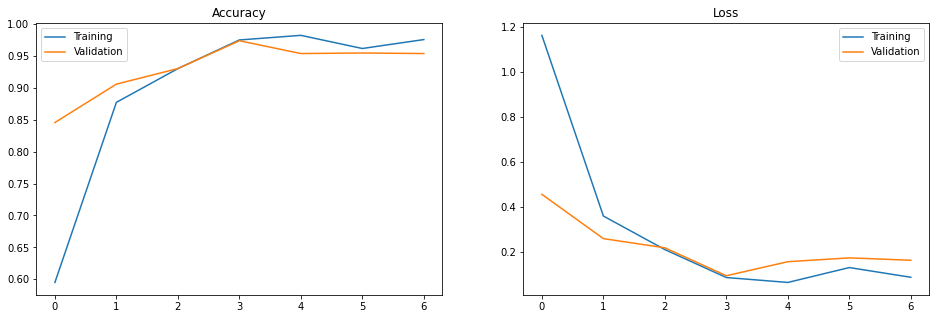

In [57]:
# Print accuracy and loss plots
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

plt.plot()

In [58]:
# Evaluate the model on test sample
performance = model.evaluate(test_images)[1]
print(f"\nOn the test sample, the model we trained, has an accuracy of {round(performance,4)*100} %")

22/22 [==============================] - 24s 1s/step - loss: 0.1117 - accuracy: 0.9630

On the test sample, the model we trained, has an accuracy of 96.3 %


We can save the model in order to use it later

In [59]:
model.save('./fish-vfin')
# model = keras.models.load_model('./fish-vfin')

INFO:tensorflow:Assets written to: ./fish-vfin/assets


### Confusion matrix

In [47]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Trout', 'Red Sea Bream', 'Red Mullet', 'Striped Red Mullet', 'Hourse Mackerel']


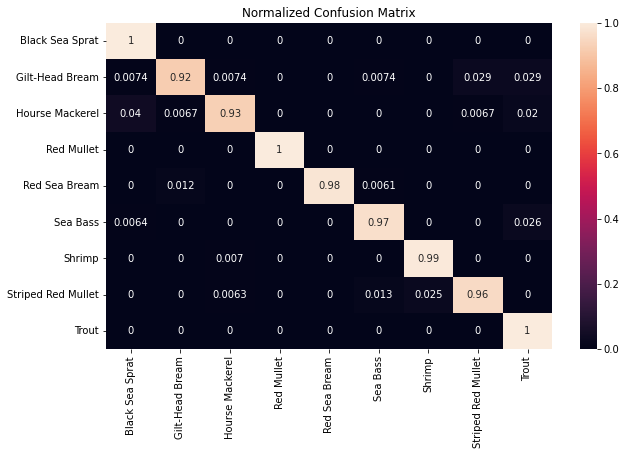

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

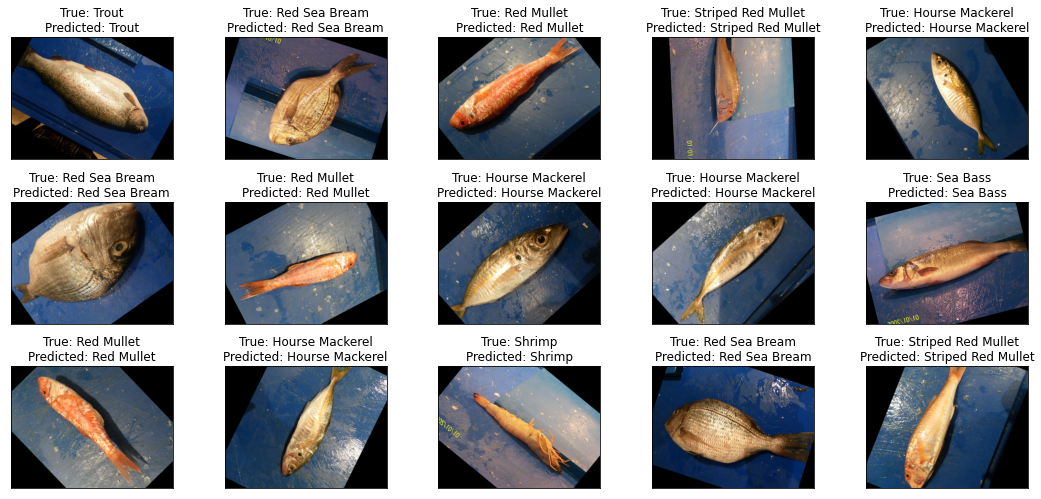

In [58]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepaths.iloc[i]))
    ax.set_title(f"True: {test_df.Labels.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()


## PCA Dimension reduction

In [42]:
train_df, test_df = train_test_split(image_df, train_size=0.85, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.15
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=6503,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1147,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1350,
    shuffle=False
)

Found 6503 validated image filenames belonging to 9 classes.
Found 1147 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


In [43]:
x_train, y_train = next(train_images)
x_val, y_val = next(val_images)
x_test, y_test = next(test_images)
print(f"Training data shape: x={x_train.shape}, y={y_train.shape}")
print(f"Validation data shape: x={x_val.shape}, y={y_val.shape}")
print(f"Test data shape: x={x_test.shape}, y={y_test.shape}")

Training data shape: x=(6503, 100, 100, 3), y=(6503, 9)
Validation data shape: x=(1147, 100, 100, 3), y=(1147, 9)
Test data shape: x=(1350, 100, 100, 3), y=(1350, 9)


In [44]:
scaler = StandardScaler(with_std=False)
x_train = scaler.fit_transform([i.flatten() for i in x_train])
x_val = scaler.fit_transform([i.flatten() for i in x_val])
x_test = scaler.fit_transform([i.flatten() for i in x_test])
print(f"Training data shape: x={x_train.shape}, y={y_train.shape}")
print(f"Validation data shape: x={x_val.shape}, y={y_val.shape}")
print(f"Test data shape: x={x_test.shape}, y={y_test.shape}")

Training data shape: x=(6503, 30000), y=(6503, 9)
Validation data shape: x=(1147, 30000), y=(1147, 9)
Test data shape: x=(1350, 30000), y=(1350, 9)


In [45]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) 
d = np.argmax(cumsum >= 0.95) + 1
print(f"The optimal number of dimensions is {d}")

The optimal number of dimensions is 1094


In [50]:
pca = PCA(n_components = d)
x_train_reduced = pca.fit_transform(x_train)
x_val_reduced = pca.transform(x_val)
x_test_reduced = pca.transform(x_test)
print(f"Training data shape: x={x_train_reduced.shape}, y={y_train.shape}")
print(f"Validation data shape: x={x_val_reduced.shape}, y={y_val.shape}")
print(f"Test data shape: x={x_test_reduced.shape}, y={y_test.shape}")

Training data shape: x=(6503, 1094), y=(6503, 9)
Validation data shape: x=(1147, 1094), y=(1147, 9)
Test data shape: x=(1350, 1094), y=(1350, 9)


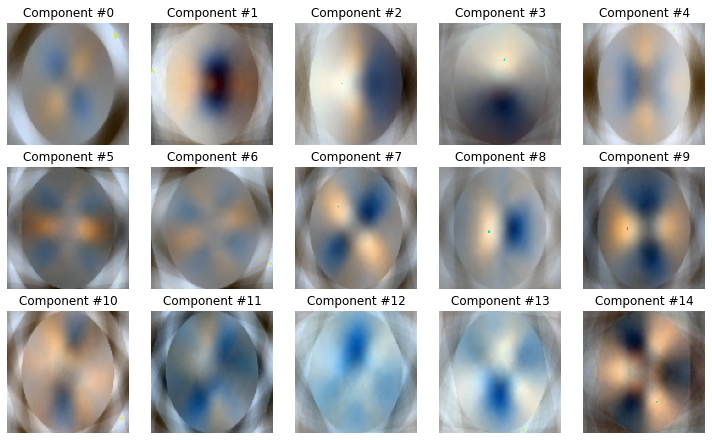

In [52]:
fig, axes = plt.subplots(3,5, figsize = (10,6),constrained_layout=True)
for i, ax in enumerate(axes.ravel()):
    img = pca.components_[i].reshape(100,100,3)
    img = (img - np.amax(img))/(np.amax(img)-np.amin(img))
    img *= 255
    ax.imshow(img.astype(np.uint8))
    ax.set_title('Component #%i' %(i))
    ax.axis('off')

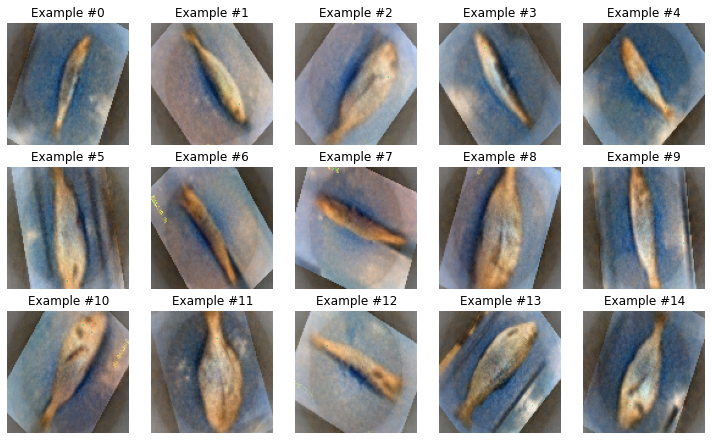

In [56]:
x_test_recovered = pca.inverse_transform(x_test_reduced)

fig, axes = plt.subplots(3,5, figsize = (10,6),constrained_layout=True)
plt.title("Examples after PCA")
for i, ax in enumerate(axes.ravel()):
    img = x_test_recovered[i].reshape(100,100,3)
    img = (img - np.amax(img))/(np.amax(img)-np.amin(img))
    img *= 255
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"Example #{i}")
    ax.axis('off')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 256)               280320    
_________________________________________________________________
dense_63 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)             

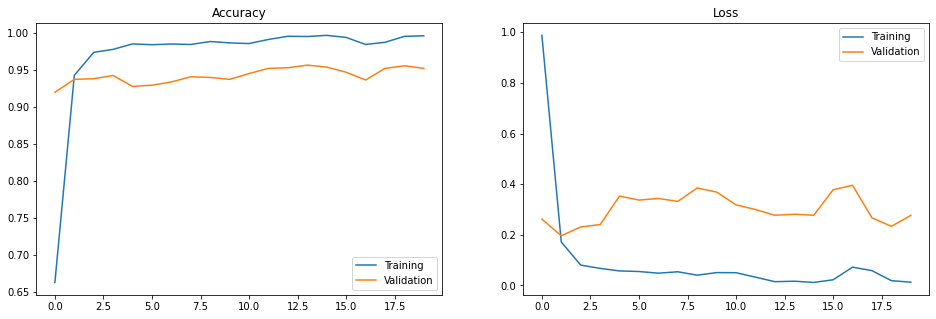

In [79]:
input_shapePCA = (1094)
modelPCA = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shapePCA),
    tf.keras.layers.Dense(256, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

modelPCA.summary()

modelPCA.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5,restore_best_weights=True)

MAX_EPOCHS = 20
history = modelPCA.fit(
    x_train_reduced, y_train,
    epochs = MAX_EPOCHS,
    validation_data = (x_val_reduced, y_val),
    #callbacks = callback
)

# Print accuracy and loss plots
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

plt.plot()

# Evaluate the model on test sample
performance = modelPCA.evaluate(x_test_reduced,y_test)[1]
print(f"\nOn the test sample, the model we trained, has an accuracy of {round(performance*100,2)} %")

## Decision Tree

In [106]:
MIN_SAMPLES_SPLIT = [2,4,6,8,10]
MAX_DEPTH = [5,10,15,20,25]

result_train = np.zeros((5,5))
result_test = np.zeros((5,5))
for i in range(len(MIN_SAMPLES_SPLIT)):
    for j in range(len(MAX_DEPTH)):
        classifier = tree.DecisionTreeClassifier(criterion="entropy",
                                        min_samples_split=MIN_SAMPLES_SPLIT[i],
                                        max_depth=MAX_DEPTH[j])
        classifier = classifier.fit(x_train_reduced, y_train)
    
        result_train[i][j]=accuracy_score(y_train, classifier.predict(x_train_reduced))
        result_test[i][j]=accuracy_score(y_test, classifier.predict(x_test_reduced))

[]

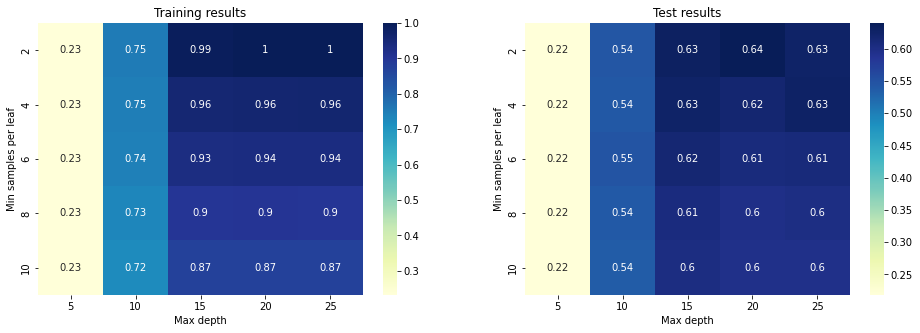

In [141]:
# Print accuracy and loss plots
_ , ax = plt.subplots(1,2,figsize=(16,5))

train_pd = pd.DataFrame(result_train, columns=MAX_DEPTH, index=MIN_SAMPLES_SPLIT)
g1 = sns.heatmap(train_pd,cmap="YlGnBu",ax=ax[0],annot=True)
g1.set_xlabel('Max depth')
g1.set_ylabel('Min samples per leaf')
g1.set_title('Training results')

test_pd = pd.DataFrame(result_test, columns=MAX_DEPTH, index=MIN_SAMPLES_SPLIT)
g2 = sns.heatmap(test_pd,cmap="YlGnBu", ax=ax[1],annot=True)
g2.set_xlabel('Max depth')
g2.set_ylabel('Min samples per leaf')
g2.set_title('Test results')

plt.plot()

In [148]:
classifier = tree.DecisionTreeClassifier(criterion="entropy",
                                        min_samples_split=2,
                                        max_depth=20)
classifier = classifier.fit(x_train_reduced, y_train)

print(f'Training accuracy: {round(accuracy_score(y_train, classifier.predict(x_train_reduced))*100,2)} %')
print(f'Test accuracy: {round(accuracy_score(y_test, classifier.predict(x_test_reduced))*100,2)} %')

Training accuracy: 100.0 %
Test accuracy: 63.56 %


## Random forest

In [156]:
rnd_forest = RandomForestClassifier(
    criterion = 'entropy',
    min_samples_split = 2,
    max_depth = 25,
    max_features = 1.0,
    ccp_alpha = 1e-4,
)
rnd_forest = rnd_forest.fit(x_train_reduced[:,:10], y_train)

print('Training accuracy: %f' %(accuracy_score(y_train, rnd_forest.predict(x_train_reduced[:,:10]))))
print('Test accuracy: %f' %(accuracy_score(y_test, rnd_forest.predict(x_test_reduced[:,:10]))))

Training accuracy: 0.997386
Test accuracy: 0.619259


## LDA

In [162]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(x_train_reduced, np.argmax(y_train, axis=1))

print('Training accuracy: %f' %(accuracy_score(np.argmax(y_train, axis = 1), lda.predict(x_train_reduced))))
print('Test accuracy: %f' %(accuracy_score(np.argmax(y_test, axis = 1), lda.predict(x_test_reduced))))

Training accuracy: 0.984776
Test accuracy: 0.948148


## Logistic regression

In [174]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='liblinear')
logistic.fit(x_train_reduced, np.argmax(y_train, axis=1))

print('Training accuracy: %f' %(accuracy_score(np.argmax(y_train, axis = 1), logistic.predict(x_train_reduced))))
print('Test accuracy: %f' %(accuracy_score(np.argmax(y_test, axis = 1), logistic.predict(x_test_reduced))))

Training accuracy: 1.000000
Test accuracy: 0.953333
